In [20]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [21]:
folder_path = "../data/jpg/"
img_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')][ : 6000]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_steps = int(BUFFER_SIZE / BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(img_files)
def load_and_preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128))
    image = tf.image.per_image_standardization(image)
    return image
train_dataset = train_dataset.map(load_and_preprocess_image)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

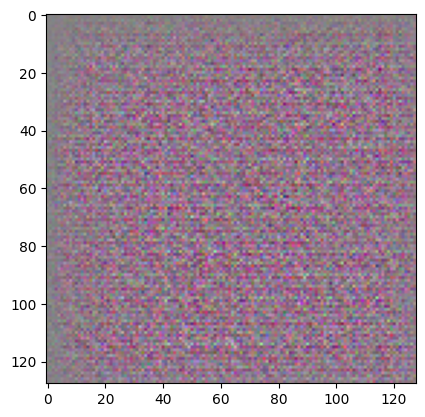

In [22]:
def gen_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None,8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5,5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 128, 128, 3)

    return model

generator = gen_model()
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)
np_img = gen_img.numpy()
scaled_images = (((np_img - np_img.min()) * 255) / (np_img.max() - np_img.min())).astype(np.uint8)
plt.imshow(scaled_images[0])

In [23]:
def disc_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same",  input_shape=[128, 128, 3]))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same"))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation=None))

    return model

disc = disc_model()
pred = disc(gen_img)
print(pred)

tf.Tensor([[-0.00022466]], shape=(1, 1), dtype=float32)


In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = '../training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=disc)

In [25]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = disc(images, training=True)
      fake_output = disc(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_disc = disc_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc, disc.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    print(f"Starting epoch: {epoch + 1}/{epochs}")
    start = time.time()
    
    step = 0
    for image_batch in dataset:
      if step % 100 == 0:
        print(f"step: {step}/{train_steps}")
      
      step += 1 
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  
  numpy_images = predictions.numpy()
  scaled_images = (((numpy_images - numpy_images.min()) * 255) / (numpy_images.max() - numpy_images.min())).astype(np.uint8)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(scaled_images[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [26]:
%%time
train(train_dataset, EPOCHS)

Starting epoch: 1/50


2023-02-08 16:20:19.974621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3469 of 60000
2023-02-08 16:20:22.302531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


step: 0/234


: 

: 